In [1]:
import os
import glob
import pickle
import ants
from tqdm import tqdm
import matplotlib.pyplot as plt
import nibabel as nib
from nibabel import processing
import numpy as np
import pandas as pd
import SimpleITK as sitk
import torch

from scipy import ndimage
from scipy.ndimage import binary_closing, binary_dilation

In [2]:
from utils.network import UNet

In [3]:
ipath = (
    #"/data2/macky/data/parcellation_280_T1/OASIS4/voxels/OAS42290.nii"
    "/data2/macky/data/parcellation_280_T1/ADNI3/voxels/002_S_0413_20170621_voxel_1.nii"
)
# 出力の名前は独自に設定
# 今は入力と同じ名前で出力している．
opath = os.path.basename(ipath)

DATASET = "TEST" #/data2/radiology_datas/clean3/TEST
OUTPUT_SS_PATH = DATASET + "/unified"
OUTPUT_PARCELLATION_PATH = DATASET + "/parcellation"

os.makedirs("N4", exist_ok=True)
os.makedirs(OUTPUT_SS_PATH, exist_ok=True)
os.makedirs(OUTPUT_PARCELLATION_PATH, exist_ok=True)

# N4 Bias Field Correction
https://ieeexplore.ieee.org/abstract/document/5445030

In [4]:
def N4_Bias_Field_Correction(input_path, output_path):
    raw_img_sitk = sitk.ReadImage(input_path, sitk.sitkFloat32)
    transformed = sitk.RescaleIntensity(raw_img_sitk, 0, 255)
    transformed = sitk.LiThreshold(transformed, 0, 1)
    head_mask = transformed
    shrinkFactor = 4
    inputImage = sitk.Shrink(raw_img_sitk, [shrinkFactor] * raw_img_sitk.GetDimension())
    maskImage = sitk.Shrink(head_mask, [shrinkFactor] * raw_img_sitk.GetDimension())
    bias_corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected = bias_corrector.Execute(inputImage, maskImage)
    log_bias_field = bias_corrector.GetLogBiasFieldAsImage(raw_img_sitk)
    corrected_image_full_resolution = raw_img_sitk / sitk.Exp(log_bias_field)
    sitk.WriteImage(corrected_image_full_resolution, output_path)
    return

In [5]:
N4_Bias_Field_Correction(ipath, f"N4/{opath}")

# 頭蓋骨除去とParcellation
以下のpaperを引用してください．<br>
Paper：https://www.medrxiv.org/content/10.1101/2024.01.18.24301494v1<br>
GitHub：https://github.com/OishiLab/OpenMAP-T1

In [6]:
print(
    "\n#######################################################################\n"
    "Please cite the following paper when using OpenMAP-T1:\n"
    "Kei Nishimaki, Kengo Onda, Kumpei Ikuta, Yuto Uchida, Hitoshi Iyatomi, Kenichi Oishi (2024).\n"
    "OpenMAP-T1: A Rapid Deep Learning Approach to Parcellate 280 Anatomical Regions to Cover the Whole Brain.\n"
    "paper: https://www.medrxiv.org/content/10.1101/2024.01.18.24301494v1.\n"
    "#######################################################################\n"
)


#######################################################################
Please cite the following paper when using OpenMAP-T1:
Kei Nishimaki, Kengo Onda, Kumpei Ikuta, Yuto Uchida, Hitoshi Iyatomi, Kenichi Oishi (2024).
OpenMAP-T1: A Rapid Deep Learning Approach to Parcellate 280 Anatomical Regions to Cover the Whole Brain.
paper: https://www.medrxiv.org/content/10.1101/2024.01.18.24301494v1.
#######################################################################



In [7]:
device = torch.device("cuda", 7) if torch.cuda.is_available() else "cpu"

CNET_MODEL_PATH = "/data2/radiology_datas/clean3/OpenMAP-T1/V2/CNet/CNet.pth"
SSNET_MODEL_PATH = "/data2/radiology_datas/clean3/OpenMAP-T1/V2/SSNet/SSNet.pth"
PNETC_MODEL_PATH = "/data2/radiology_datas/clean3/OpenMAP-T1/V2/PNet/coronal.pth"
PNETS_MODEL_PATH = "/data2/radiology_datas/clean3/OpenMAP-T1/V2/PNet/sagittal.pth"
PNETA_MODEL_PATH = "/data2/radiology_datas/clean3/OpenMAP-T1/V2/PNet/axial.pth"
HNETC_MODEL_PATH = "/data2/radiology_datas/clean3/OpenMAP-T1/V2/HNet/coronal.pth"
HNETA_MODEL_PATH = "/data2/radiology_datas/clean3/OpenMAP-T1/V2/HNet/axial.pth"

cnet = UNet(1, 1)
cnet.load_state_dict(torch.load(CNET_MODEL_PATH))
cnet.to(device)
cnet.eval()

ssnet = UNet(1, 1)
ssnet.load_state_dict(torch.load(SSNET_MODEL_PATH))
ssnet.to(device)
ssnet.eval()

pnet_c = UNet(3, 142)
pnet_c.load_state_dict(torch.load(PNETC_MODEL_PATH))
pnet_c.to(device)
pnet_c.eval()

pnet_s = UNet(3, 142)
pnet_s.load_state_dict(torch.load(PNETS_MODEL_PATH))
pnet_s.to(device)
pnet_s.eval()

pnet_a = UNet(3, 142)
pnet_a.load_state_dict(torch.load(PNETA_MODEL_PATH))
pnet_a.to(device)
pnet_a.eval()

hnet_c = UNet(1, 3)
hnet_c.load_state_dict(torch.load(HNETC_MODEL_PATH))
hnet_c.to(device)
hnet_c.eval()

hnet_a = UNet(1, 3)
hnet_a.load_state_dict(torch.load(HNETA_MODEL_PATH))
hnet_a.to(device)
hnet_a.eval()

print("load")

load


## Croppingフェーズ

In [8]:
def normalize(voxel):
    nonzero = voxel[voxel > 0]
    voxel = np.clip(voxel, 0, np.mean(nonzero) + np.std(nonzero) * 2)
    voxel = (voxel - np.min(voxel)) / (np.max(voxel) - np.min(voxel))
    voxel = (voxel * 2) - 1
    return voxel.astype("float32")


def crop(voxel, model, device):
    model.eval()
    with torch.inference_mode():
        output = torch.zeros(256, 256, 256).to(device)
        for i, image in enumerate(voxel):
            image = image.reshape(1, 1, 256, 256)
            image = torch.tensor(image).to(device)
            x_out = torch.sigmoid(model(image)).detach()
            output[i] = x_out
        return output.reshape(256, 256, 256)


def closing(out_e):
    selem = np.ones((3, 3, 3), dtype="bool")
    out_e = binary_closing(out_e, structure=selem, iterations=3)
    return out_e


def cropping(data, cnet, device):
    voxel = data.get_fdata().astype("float32")
    voxel = normalize(voxel)

    coronal = voxel.transpose(1, 2, 0)
    sagittal = voxel
    out_c = crop(coronal, cnet, device).permute(2, 0, 1)
    out_s = crop(sagittal, cnet, device)
    out_e = ((out_c + out_s) / 2) > 0.5
    out_e = out_e.cpu().numpy()
    out_e = closing(out_e)
    cropped = data.get_fdata().astype("float32") * out_e
    return cropped

In [9]:
odata = nib.squeeze_image(nib.as_closest_canonical(nib.load(f"N4/{opath}")))
data = processing.conform(
    odata, out_shape=(256, 256, 256), voxel_size=(1.0, 1.0, 1.0), order=1
)
cropped = cropping(data, cnet, device)

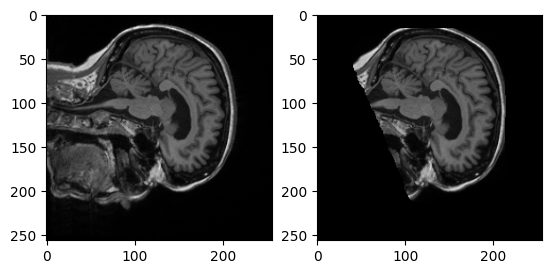

In [10]:
plt.subplot(1, 2, 1)
plt.imshow(data.get_fdata().astype("float32")[120], cmap="gray")

plt.subplot(1, 2, 2)
plt.imshow(cropped[120], cmap="gray")

## Skull-Strippingフェーズ

In [11]:
def strip(voxel, model, device):
    model.eval()
    with torch.inference_mode():
        output = torch.zeros(256, 256, 256).to(device)
        for i, image in enumerate(voxel):
            image = image.reshape(1, 1, 256, 256)
            image = torch.tensor(image).to(device)
            x_out = torch.sigmoid(model(image)).detach()
            output[i] = x_out
        return output.reshape(256, 256, 256)


def stripping(voxel, data, ssnet, device):
    voxel = normalize(voxel)

    coronal = voxel.transpose(1, 2, 0)
    sagittal = voxel
    axial = voxel.transpose(2, 1, 0)
    out_c = strip(coronal, ssnet, device).permute(2, 0, 1)
    out_s = strip(sagittal, ssnet, device)
    out_a = strip(axial, ssnet, device).permute(2, 1, 0)
    out_e = ((out_c + out_s + out_a) / 3) > 0.5
    out_e = out_e.cpu().numpy()
    stripped = data.get_fdata().astype("float32") * out_e

    x, y, z = map(int, ndimage.center_of_mass(out_e))
    xd = 128 - x
    yd = 120 - y
    zd = 128 - z
    stripped_shift = np.roll(stripped, (xd, yd, zd), axis=(0, 1, 2))
    stripped_shift = stripped_shift[32:-32, 16:-16, 32:-32]
    return stripped, stripped_shift, (xd, yd, zd)

In [12]:
stripped, stripped_shift, shift = stripping(cropped, data, ssnet, device)

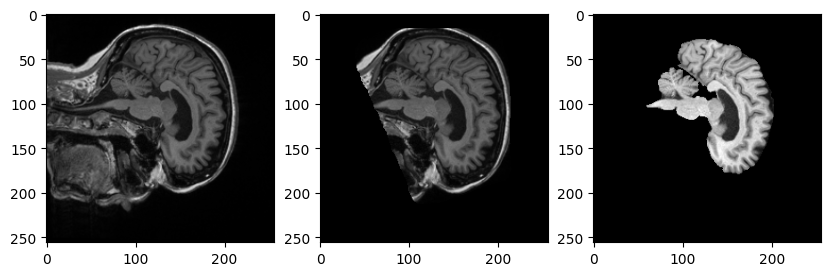

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(data.get_fdata().astype("float32")[120], cmap="gray")

plt.subplot(1, 3, 2)
plt.imshow(cropped[120], cmap="gray")

plt.subplot(1, 3, 3)
plt.imshow(stripped[120], cmap="gray")

In [14]:
nii = nib.Nifti1Image(stripped.astype(np.float32), affine=data.affine)
nib.save(nii, f"{OUTPUT_SS_PATH}/{opath}")

## Parcellationフェーズ

In [15]:
def parcellate(voxel, model, device, mode):
    if mode == "c":
        stack = (224, 192, 192)
    elif mode == "s":
        stack = (192, 224, 192)
    elif mode == "a":
        stack = (192, 224, 192)
    model.eval()
    voxel = np.pad(
        voxel, [(1, 1), (0, 0), (0, 0)], "constant", constant_values=voxel.min()
    )
    with torch.inference_mode():
        box = torch.zeros(stack[0], 142, stack[1], stack[2])
        for i in range(stack[0]):
            i += 1
            image = np.stack([voxel[i - 1], voxel[i], voxel[i + 1]])
            image = torch.tensor(image.reshape(1, 3, stack[1], stack[2]))
            image = image.to(device)
            x_out = torch.softmax(model(image), 1).detach().cpu()
            if i == 1:
                box[0] = x_out
            else:
                box[i - 1] = x_out
        return box.reshape(stack[0], 142, stack[1], stack[2])


def parcellation(voxel, pnet_c, pnet_s, pnet_a, device):
    voxel = normalize(voxel)

    coronal = voxel.transpose(1, 2, 0)
    sagittal = voxel
    axial = voxel.transpose(2, 1, 0)
    out_c = parcellate(coronal, pnet_c, device, "c").permute(1, 3, 0, 2)
    torch.cuda.empty_cache()
    out_s = parcellate(sagittal, pnet_s, device, "s").permute(1, 0, 2, 3)
    torch.cuda.empty_cache()
    out_e = out_c + out_s
    del out_c, out_s
    out_a = parcellate(axial, pnet_a, device, "a").permute(1, 3, 2, 0)
    torch.cuda.empty_cache()
    out_e = out_e + out_a
    del out_a
    parcellated = torch.argmax(out_e, 0).numpy()
    return parcellated

In [16]:
parcellated = parcellation(stripped_shift, pnet_c, pnet_s, pnet_a, device)

## Hemisphereフェーズ

In [17]:
def separate(voxel, model, device, mode):
    if mode == "c":
        stack = (224, 192, 192)
    elif mode == "a":
        stack = (192, 224, 192)
    model.eval()
    with torch.inference_mode():
        output = torch.zeros(stack[0], 3, stack[1], stack[2]).to(device)
        for i, v in enumerate(voxel):
            image = torch.tensor(v.reshape(1, 1, stack[1], stack[2]))
            image = image.to(device)
            x_out = torch.softmax(model(image), 1).detach()
            output[i] = x_out
        return output


def hemisphere(voxel, hnet_c, hnet_a, device):
    voxel = normalize(voxel)

    coronal = voxel.transpose(1, 2, 0)
    transverse = voxel.transpose(2, 1, 0)
    out_c = separate(coronal, hnet_c, device, "c").permute(1, 3, 0, 2)
    out_a = separate(transverse, hnet_a, device, "a").permute(1, 3, 2, 0)
    out_e = out_c + out_a
    out_e = torch.argmax(out_e, 0).cpu().numpy()
    torch.cuda.empty_cache()

    dilated_mask_1 = binary_dilation(out_e == 1, iterations=5).astype("int16")
    dilated_mask_1[out_e == 2] = 2
    dilated_mask_2 = (
        binary_dilation(dilated_mask_1 == 2, iterations=5).astype("int16") * 2
    )
    dilated_mask_2[dilated_mask_1 == 1] = 1
    return dilated_mask_2

In [18]:
separated = hemisphere(stripped_shift, hnet_c, hnet_a, device)

## 最終マージ

In [19]:
def postprocessing(parcellated, separated, shift, device):
    with open("utils/split_map.pkl", "rb") as tf:
        dictionary = pickle.load(tf)

    pmap = torch.tensor(parcellated.astype("int16"), requires_grad=False).to(
        device
    )
    hmap = torch.tensor(separated.astype("int16"), requires_grad=False).to(
        device
    )
    combined = torch.stack(
        (torch.flatten(hmap), torch.flatten(pmap)), axis=-1
    )
    output = torch.zeros_like(hmap).ravel()
    for key, value in dictionary.items():
        key = torch.tensor(key, requires_grad=False).to(device)
        mask = torch.all(combined == key, axis=1)
        output[mask] = value
    output = output.reshape(hmap.shape)
    output = output.cpu().detach().numpy()
    output = output * (
        np.logical_or(
            np.logical_or(separated > 0, parcellated == 87), parcellated == 138
        )
    )
    output = np.pad(
        output, [(32, 32), (16, 16), (32, 32)], "constant", constant_values=0
    )
    output = np.roll(output, (-shift[0], -shift[1], -shift[2]), axis=(0, 1, 2))
    return output

In [20]:
output = postprocessing(parcellated, separated, shift, device)

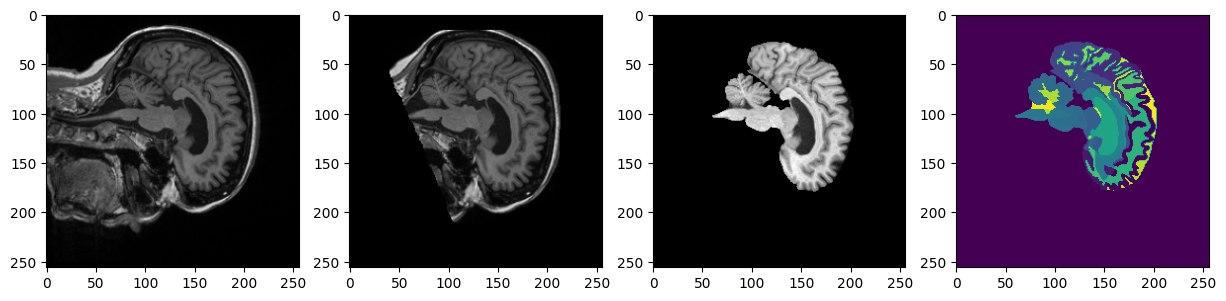

In [21]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(data.get_fdata().astype("float32")[120], cmap="gray")

plt.subplot(1, 4, 2)
plt.imshow(cropped[120], cmap="gray")

plt.subplot(1, 4, 3)
plt.imshow(stripped[120], cmap="gray")

plt.subplot(1, 4, 4)
plt.imshow(output[120])

In [22]:
nii = nib.Nifti1Image(output.astype(np.uint16), affine=data.affine)
nib.save(nii, f"{OUTPUT_PARCELLATION_PATH}/{opath}")

# Affine変換

In [24]:
DATASET = "TEST"
OUTPUT_RIGID_FULL_PATH = DATASET + "/full/rigid"
OUTPUT_TRSAA_FULL_PATH = DATASET + "/full/trsaa"
OUTPUT_RIGID_HALF_PATH = DATASET + "/half/rigid"
OUTPUT_TRSAA_HALF_PATH = DATASET + "/half/trsaa"
os.makedirs(OUTPUT_RIGID_FULL_PATH, exist_ok=True)
os.makedirs(OUTPUT_TRSAA_FULL_PATH, exist_ok=True)
os.makedirs(OUTPUT_RIGID_HALF_PATH, exist_ok=True)
os.makedirs(OUTPUT_TRSAA_HALF_PATH, exist_ok=True)

In [27]:
data = nib.squeeze_image(
    nib.as_closest_canonical(nib.load(f"{OUTPUT_SS_PATH}/{opath}"))
)
data_mask = nib.Nifti1Image(
    (data.get_fdata() > 0).astype(np.uint16), affine=data.affine
)

MNI_PATH = "/data2/radiology_datas/clean3/MNI/MNI_FULL.nii"
mni = nib.squeeze_image(nib.as_closest_canonical(nib.load(MNI_PATH)))

data_ants = ants.from_nibabel(data)
mask_ants = ants.from_nibabel(data_mask)
mni_ants = ants.from_nibabel(mni)

In [35]:
tx = ants.registration(mni_ants, data_ants, type_of_transform="Rigid")
data_tx_rigid = nib.as_closest_canonical(ants.to_nibabel(tx["warpedmovout"]))

data_mask_tx_rigid = nib.as_closest_canonical(
    ants.to_nibabel(
        ants.apply_transforms(
            fixed=mni_ants,
            moving=mask_ants,
            transformlist=tx["fwdtransforms"],
            interpolator="nearestNeighbor",
        )
    )
)
data_tx_rigid = nib.Nifti1Image(
    (data_tx_rigid.get_fdata() * data_mask_tx_rigid.get_fdata()).astype(np.float32),
    affine=data_tx_rigid.affine,
)

nib.save(data_tx_rigid, f"{OUTPUT_RIGID_FULL_PATH}/{opath}")
data_tx_rigid_half = processing.conform(
    data_tx_rigid, out_shape=(80, 112, 80), voxel_size=(2.0, 2.0, 2.0), order=1
)
nib.save(data_tx_rigid_half, f"{OUTPUT_RIGID_HALF_PATH}/{opath}")

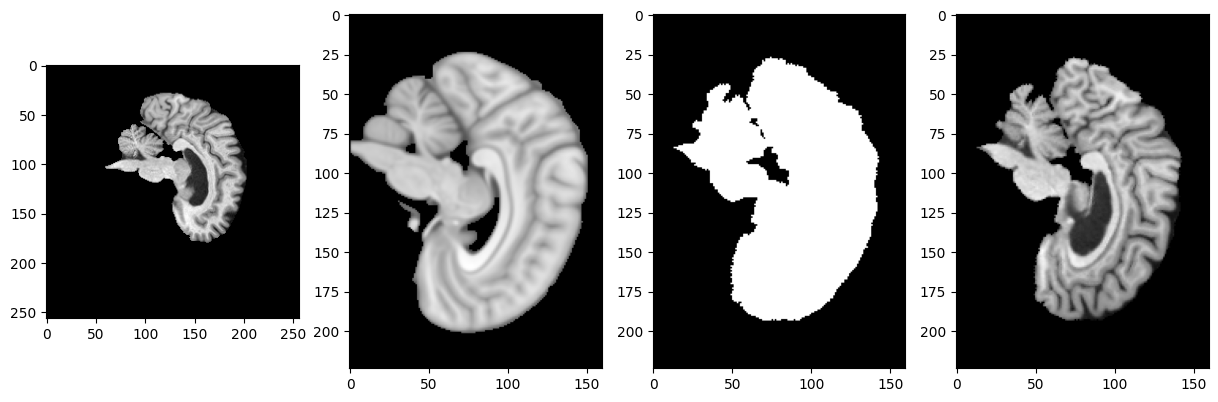

In [36]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(data.get_fdata().astype("float32")[120], cmap="gray")

plt.subplot(1, 4, 2)
plt.imshow(mni.get_fdata().astype("float32")[75], cmap="gray")

plt.subplot(1, 4, 3)
plt.imshow(data_mask_tx_rigid.get_fdata().astype("float32")[75], cmap="gray")

plt.subplot(1, 4, 4)
plt.imshow(data_tx_rigid.get_fdata().astype("float32")[75], cmap="gray")

In [37]:
tx = ants.registration(mni_ants, data_ants, type_of_transform="TRSAA")
data_tx_trsaa = nib.as_closest_canonical(ants.to_nibabel(tx["warpedmovout"]))
data_mask_tx_trsaa = nib.as_closest_canonical(
    ants.to_nibabel(
        ants.apply_transforms(
            fixed=mni_ants,
            moving=mask_ants,
            transformlist=tx["fwdtransforms"],
            interpolator="nearestNeighbor",
        )
    )
)
data_tx_trsaa = nib.Nifti1Image(
    (data_tx_trsaa.get_fdata() * data_mask_tx_trsaa.get_fdata()).astype(np.float32),
    affine=data_tx_trsaa.affine,
)

nib.save(data_tx_trsaa, f"{OUTPUT_TRSAA_FULL_PATH}/{opath}")
data_tx_trsaa_half = processing.conform(
    data_tx_trsaa, out_shape=(80, 112, 80), voxel_size=(2.0, 2.0, 2.0), order=1
)
nib.save(data_tx_trsaa_half, f"{OUTPUT_TRSAA_HALF_PATH}/{opath}")

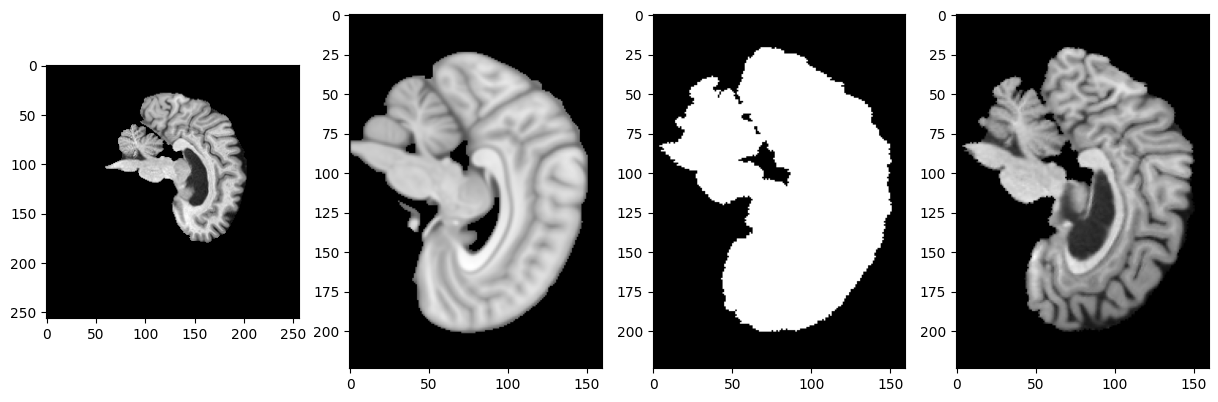

In [38]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(data.get_fdata().astype("float32")[120], cmap="gray")

plt.subplot(1, 4, 2)
plt.imshow(mni.get_fdata().astype("float32")[75], cmap="gray")

plt.subplot(1, 4, 3)
plt.imshow(data_mask_tx_trsaa.get_fdata().astype("float32")[75], cmap="gray")

plt.subplot(1, 4, 4)
plt.imshow(data_tx_trsaa.get_fdata().astype("float32")[75], cmap="gray")

# 体積情報の取得方法
すべてのデータセットの体積情報は/data2/radiology_datas/clean3/meta/csv/~~に保存されている．

## Full

In [24]:
PATH = "/home/macky/open/Preprocess/TEST/parcellation"

In [25]:
pathes = sorted(glob.glob(f"{PATH}/*.nii"))

df = pd.read_table("level/Level5.txt", delimiter="\s+", names=["number", "region"])
df = df.astype(str)
df = df.set_index("number")

for ipath in tqdm(pathes):
    data = nib.squeeze_image(nib.as_closest_canonical(nib.load(ipath)))
    resolution = data.header["pixdim"][1] * data.header["pixdim"][2] * data.header["pixdim"][3]
    voxel = data.get_fdata().astype("int")
    save = os.path.basename(ipath).replace(".nii","")
    for i in range(280):
        i += 1
        volume = np.count_nonzero(voxel == i) * resolution
        df.loc[str(i), save] = volume
df.T.to_csv("TEST/FULL_volume.csv", header=False)

100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


## Half（左右の平均）

In [75]:
df_full = pd.read_csv("FULL_volume.csv")

def average(df):
    averages = {}
    for column in df.columns:
        if column.endswith('_L') or column.endswith('_R'):
            prefix = column[:-2]
            if prefix not in averages:
                averages[prefix] = []
            averages[prefix].append(column)
    return averages

def calculation(averages, df):
    for prefix, columns in averages.items():
        df[prefix] = df[columns].mean(axis=1)
    columns_to_drop = [col for col in df.columns if "_L" in col[-2:] or "_R" in col[-2:]]
    df = df.drop(columns=columns_to_drop)
    return df

averages = average(df_full)
df_half = calculation(averages, df_full)
df_half.to_csv("TEST/Half_volume.csv", index=False)
df_half

,region,III_ventricle,IV_ventricle,SFG,SFG_PFC,SFG_pole,MFG,MFG_DPFC,IFG_opercularis,IFG_orbitalis,...,ParietSul,CinguSul,OcciptSul,TempSul,Caudate_tail,Fimbria,Chroid_LVetc,ECCL,ECSAnterior,ECSPosterior
0,OAS42290,1104.0,1688.0,10821.0,8195.5,2762.5,5298.0,9689.0,1972.5,2205.0,...,15131.0,2128.5,2955.0,618.0,249.0,0.0,213.5,324.0,1701.5,2195.5
